<a href="https://colab.research.google.com/github/s-kamireddy/hw4/blob/main/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

import torch
import torch.nn as nn
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#EDA
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)
df = pd.read_csv(path +'/IMDB Dataset.csv')

100%|██████████| 25.7M/25.7M [00:00<00:00, 67.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1


In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.shape
df.isna().sum()

,0
review,0
sentiment,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


Perform some preprocessing

In [ ]:
def lower_text(text):
    return [item.lower() for item in text ]

#split the sentences into words
df['review'] = df['review'].apply(lower_text)
df = df[['review', 'sentiment']]

#map + - to 1 and 0
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

vocab = set([word for review in df['review'] for word in review])
vocab_size = len(vocab)

word_to_index = {word: index for index, word in enumerate(vocab)}

def encode_review(review):
    return [word_to_index[word] for word in review]

df['review'] = df['review'].apply(encode_review)

max_review_len = max(len(review) for review in df['review'])

df['review'] = df['review'].apply(lambda x: x + [0]*(max_review_len-len(x)))




In [ ]:
class reviewsDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.texts = data['review'].values
        self.labels = data['sentiment'].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        return torch.tensor(text, dtype=torch.long), torch.tensor(label, dtype=torch.float32)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = reviewsDataset(train_df)
test_dataset = reviewsDataset(test_df)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

TASK 2:
------
 In this task, you will pick a dataset (time-series or any other form of sequential data) and an associated problem that can be solved via sequence models. You must describe why you need sequence models to solve this problem. Include a link to the dataset source. Next, you should pick an RNN framework that you would use to solve this problem (This framework can be in TensorFlow, PyTorch or any other Python Package).

Task 2 - Part 1: Implementing an RNN Using Pytorch
Refrencing this tutorial on the RNN module and embedding: https://www.geeksforgeeks.org/implementing-recurrent-neural-networks-in-pytorch/#steps-to-build-an-rnn

The metrics we will use to evaluate will be F1 score and general accuracy as the output is binary (positive or negative)

In [ ]:
class Rnn(nn.Module):
  def __init__(self, hidden_size, output_size, vocab_size):
    super(Rnn, self).__init__()
    self.rnn = nn.RNN(vocab_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    x = torch.nn.functional.one_hot(x, num_classes=vocab_size + 1).type(torch.float32)
    h0 = torch.zeros(1, x.size(0), self.rnn.hidden_size).to(x.device)
    out, _ = self.rnn(x)
    out = self.fc(out)
    return out

In [ ]:
hidden_size = 30
output_size = 1
model = Rnn( hidden_size, output_size, vocab_size + 1)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#training
epochs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

for epoch in range(epochs):
  model.train()
  epoch_loss = 0

  for reviews, sentiments in train_loader:
    reviews, sentiments = reviews.to(device), sentiments.to(device)
    outputs = model(torch.tensor(reviews, dtype = torch.int64))
    loss = criterion(outputs, sentiments)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

cuda
Epoch 1/10, Loss: 0.25097399950027466
Epoch 2/10, Loss: 0.2512412965297699
Epoch 3/10, Loss: 0.2499472200870514
Epoch 4/10, Loss: 0.2514701187610626
Epoch 5/10, Loss: 0.2502780556678772
Epoch 6/10, Loss: 0.24904213845729828
Epoch 7/10, Loss: 0.2476835697889328
Epoch 8/10, Loss: 0.2572289705276489
Epoch 9/10, Loss: 0.2500298023223877
Epoch 10/10, Loss: 0.2501823306083679


In [ ]:
model.eval()

Rnn(
  (rnn): RNN(163, 30, batch_first=True)
  (fc): Linear(in_features=30, out_features=1, bias=True)
)

In [ ]:
correct = 0
total = 0
f1 = 0

def precision(y_pred, y_true):
  tp = torch.sum((y_pred > 0.5 ) & (y_true == 1)).item()
  fp = torch.sum((y_pred > 0.5) & (y_true == 0)).item()
  if tp + fp == 0:
    return 0
  return tp / (tp + fp)

def recall(y_pred, y_true):
  tp = torch.sum((y_pred > 0.5) & (y_true == 1)).item()
  fn = torch.sum((y_pred <=0.5) & (y_true == 1)).item()
  if tp + fn == 0:
    return 0
  return tp / (tp + fn)

def F1_score(y_pred, y_true):
  precision_val = precision(y_pred, y_true)
  recall_val = recall(y_pred, y_true)
  if precision_val + recall_val == 0:
    return 0
  return 2 * (precision_val * recall_val) / (precision_val + recall_val)

with torch.no_grad():
    for texts, labels in test_loader:
        texts = texts.to(device)
        labels = labels.to(device)
        outputs = model(texts)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        f1 += F1_score(predicted, labels)

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')
print(f'F1 Score: {f1/len(test_loader):.2f}')

Accuracy: 47.18%
F1 Score: 0.67


Part 2: LSTM and GRU implementation

In [ ]:
class LSTM(nn.Module):
  def __init__(self, hidden_size, output_size, vocab_size):
    super(LSTM, self).__init__()
    self.lstm = nn.LSTM(vocab_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = torch.nn.functional.one_hot(x, num_classes=vocab_size + 1).type(torch.float32)
    h0 = torch.zeros(1, x.size(0), self.lstm.hidden_size).to(x.device)
    out, _ = self.lstm(x)
    out = self.fc(out)
    return out

In [ ]:
class GRU(nn.Module):
  def __init__(self, hidden_size, output_size, vocab_size):
    super(GRU, self).__init__()
    self.gru = nn.GRU(vocab_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = torch.nn.functional.one_hot(x, num_classes=vocab_size + 1).type(torch.float32)
    h0 = torch.zeros(1, x.size(0), self.gru.hidden_size).to(x.device)
    out, _ = self.gru(x)
    out = self.fc(out[:, -1, :])
    return out

In [ ]:
#training
model = LSTM( hidden_size, output_size, vocab_size + 1)
epochs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)



for epoch in range(epochs):
  model.train()
  epoch_loss = 0

  for reviews, sentiments in train_loader:
    reviews, sentiments = reviews.to(device), sentiments.to(device)
    outputs = model(torch.tensor(reviews, dtype = torch.int64))
    loss = criterion(outputs, sentiments)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

cuda
Epoch 1/10, Loss: 0.7879716157913208
Epoch 2/10, Loss: 0.8289956450462341
Epoch 3/10, Loss: 0.7468629479408264
Epoch 4/10, Loss: 0.6623174548149109
Epoch 5/10, Loss: 0.7451044321060181
Epoch 6/10, Loss: 0.9552590847015381
Epoch 7/10, Loss: 0.7450563907623291
Epoch 8/10, Loss: 0.6198074817657471
Epoch 9/10, Loss: 0.6196976900100708
Epoch 10/10, Loss: 0.7878618836402893


In [ ]:
correct = 0
total = 0
f1 = 0

with torch.no_grad():
    for texts, labels in test_loader:
        texts = texts.to(device)
        labels = labels.to(device)
        outputs = model(texts)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        f1 += F1_score(predicted, labels)

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')
print(f'F1 Score: {f1/len(test_loader):.2f}')

Accuracy: 57.53%
F1 Score: 0.66


In [ ]:
#training
model = GRU(hidden_size, output_size, vocab_size + 1)
epochs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)



for epoch in range(epochs):
  model.train()
  epoch_loss = 0

  for reviews, sentiments in train_loader:
    reviews, sentiments = reviews.to(device), sentiments.to(device)
    outputs = model(torch.tensor(reviews, dtype = torch.int64))
    loss = criterion(outputs, sentiments)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

cuda
Epoch 1/10, Loss: 0.4872153401374817
Epoch 2/10, Loss: 0.5176558494567871
Epoch 3/10, Loss: 0.3045724928379059
Epoch 4/10, Loss: 0.36545342206954956
Epoch 5/10, Loss: 0.7002986669540405
Epoch 6/10, Loss: 0.4872153401374817
Epoch 7/10, Loss: 0.4872153401374817
Epoch 8/10, Loss: 0.5480962991714478
Epoch 9/10, Loss: 0.5480962991714478
Epoch 10/10, Loss: 0.5785367488861084


In [ ]:
correct = 0
total = 0
f1 = 0

with torch.no_grad():
    for texts, labels in test_loader:
        texts = texts.to(device)
        labels = labels.to(device)
        outputs = model(texts)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        f1 += F1_score(predicted, labels)

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')
print(f'F1 Score: {f1/len(test_loader):.2f}')

Accuracy: 49.61%
F1 Score: 0.00


LSTM memory faired the best of of the three implementations as LSTM handles the porblem of the vanishing gradient, and can handle the longer term dependencies in complex sentences better than vanilla RNNs and RNNs with GRU

Part 3:
 Can you use the traditional feed-forward network to solve the same problem. Why or why not?   (Hint: Can time series data be converted to usual features that can be used as input to a feed-forward network?)

 Yes we can, using vector embeddings, we can capture the relationships between words and their meanings within sentences.

Task 3:
-----
Part 1: implementing word embeddings.

I will be using FastText, as it considers how likley two words are to appear in a given context, and can handle out-of-vocabulary words, unlike Word2Vec. GloVe considers global context, unlike FastText, but has no way to account for out-of-vocabulary words. While BERT is computationally costly.

Resources used: https://www.geeksforgeeks.org/word-embeddings-using-fasttext/

In [ ]:
from gensim.models import FastText
from gensim.test.utils import common_texts
from sklearn.decomposition import PCA

In [ ]:
# Example corpus (replace with your own corpus)
corpus = common_texts

# Training FastText model
model = FastText(sentences=corpus, vector_size=100, window=5, min_count=1, workers=4, sg=1)

Out-of-vocab words are handled automatically by fasttext

In [ ]:
#Input 2 words here:
word1 = "Sahithi"
word2 = "computer"

embed1 = model.wv[word1]
embed2 = model.wv[word2]

#printing the vector embeddings
print(word1, embed1)
print(word2,embed2)


print("words most similar to", word1, model.wv.most_similar(word1))
print("words most similar to", word2, model.wv.most_similar(word2))



Sahithi [ 6.8399572e-04 -1.0178236e-03  1.4469080e-03  9.9590812e-05
 -1.5204321e-03  1.5697692e-03  8.7922806e-04 -3.1575951e-04
  1.4440817e-03 -1.5502032e-03 -1.9516480e-03  4.2941311e-04
  9.5572596e-04 -7.0532446e-04 -4.2427666e-04  5.2066898e-04
 -1.7215862e-04  1.7316829e-03 -4.9256108e-04 -1.5028018e-04
  2.3634225e-04 -3.6528552e-05  7.9110393e-04 -9.4822032e-04
 -2.5068121e-03 -9.1642793e-04 -3.1150176e-04 -1.0458439e-03
  9.5027481e-04  1.4095636e-03  1.6057105e-03  1.5452642e-04
 -1.4265742e-03 -1.2964047e-04 -2.4064030e-03 -1.8334445e-03
 -7.5784919e-04 -1.1076125e-03  1.1662082e-03  1.1708462e-03
 -6.1593845e-04 -5.3710677e-04  4.5584078e-04 -1.0537934e-03
 -1.3054600e-03 -1.2429000e-03 -1.9248211e-04 -1.4393621e-03
 -1.4299724e-03  6.4332486e-04 -2.2118763e-04 -1.9241449e-04
 -1.2859468e-03 -2.2608147e-03 -3.0523015e-04 -1.8953698e-03
 -4.1061445e-04 -2.7529534e-03  1.0337591e-03 -1.3836961e-04
 -9.0028811e-04 -1.7645393e-03 -6.8631949e-04  4.4199729e-05
 -6.3364266e-04 

Part 2: Cosine Similarity

In [ ]:
def cosineSimilarity(x,y):
    cosi = torch.nn.CosineSimilarity(dim=0)
    return cosi(x, y).item()

In [ ]:
#input multiple words here
words = ["banana", "car", "computer", "fruit", "bus", "truck", "ship", "train", "Sahithi"]

In [ ]:
vectors = [torch.tensor(model.wv[word]) for word in words]
for i in range(len(vectors)):
    for j in range(len(vectors)):
        if i != j:
            print("cosine similarity of", words[i], "and", words[j],":", cosineSimilarity(vectors[i],vectors[j]))

cosine similarity of banana and car : -0.023161746561527252
cosine similarity of banana and computer : 0.10580457001924515
cosine similarity of banana and fruit : -0.07827246189117432
cosine similarity of banana and bus : 0.00718080997467041
cosine similarity of banana and truck : 0.15925398468971252
cosine similarity of banana and ship : 0.010793609544634819
cosine similarity of banana and train : -0.15123732388019562
cosine similarity of banana and Sahithi : -0.02119796723127365
cosine similarity of car and banana : -0.023161746561527252
cosine similarity of car and computer : 0.11254262179136276
cosine similarity of car and fruit : 0.16221103072166443
cosine similarity of car and bus : -0.1409793496131897
cosine similarity of car and truck : 0.04577180743217468
cosine similarity of car and ship : 0.18721415102481842
cosine similarity of car and train : -0.13055387139320374
cosine similarity of car and Sahithi : -0.011821269989013672
cosine similarity of computer and banana : 0.10580

In [ ]:
vectors = torch.stack(vectors).numpy()  # Stack tensors and convert to NumPy
pca = PCA(n_components = 2)
components = pca.fit_transform(vectors)


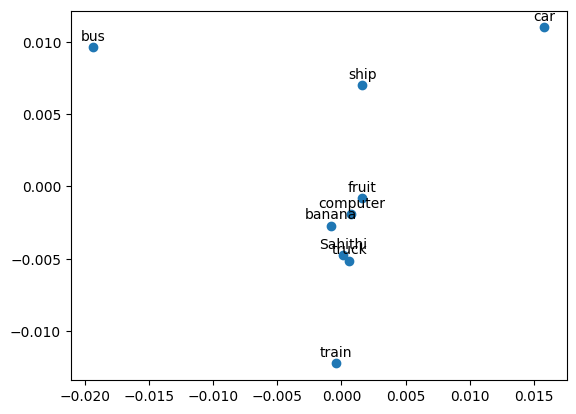

In [ ]:
plt.scatter(components[:, 0], components[:, 1])
for i, label in enumerate(words):
    plt.annotate(label, (components[i][0], components[i][1]), textcoords="offset points", xytext=(0,5), ha='center')

Part 3

In [ ]:
def euclidean_distance(x, y):
  return torch.cdist(x,y,p=2)


Unlike cosine similarity, euclidean distance captures the magnitude of the difference between the vectors

In [ ]:
def visualize_dissimilarity(words, metric):
  vectors = [torch.tensor(model.wv[word]) for word in words]
  vectors = torch.stack(vectors)
  distances = None
  if metric == 'cosine':
    distances = torch.cdist(vectors, vectors, p=2)
  elif metric == 'euclidean':
    distances = euclidean_distance(vectors, vectors)


  sns.heatmap(distances, xticklabels=words, yticklabels=words, cmap='viridis')
  plt.title("Similarity Heatmap")
  plt.show()

  for i, word in enumerate(words):
    dists = distances[i]
    sorted_indexes = np.argsort(dists)
    print("ranking for", word)
    ct= 1
    for index in sorted_indexes[1::]:
      print(ct, words[index])
      ct+=1



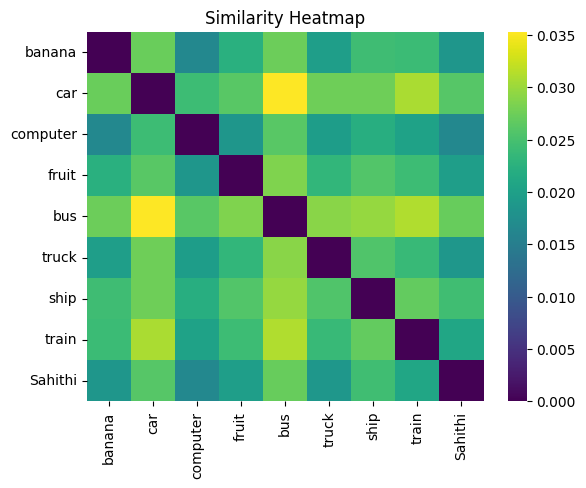

ranking for banana
1 computer
2 Sahithi
3 truck
4 fruit
5 train
6 ship
7 car
8 bus
ranking for car
1 computer
2 Sahithi
3 fruit
4 banana
5 truck
6 ship
7 train
8 bus
ranking for computer
1 Sahithi
2 banana
3 fruit
4 truck
5 train
6 ship
7 car
8 bus
ranking for fruit
1 computer
2 Sahithi
3 banana
4 truck
5 train
6 ship
7 car
8 bus
ranking for bus
1 computer
2 Sahithi
3 banana
4 fruit
5 truck
6 ship
7 train
8 car
ranking for truck
1 Sahithi
2 computer
3 banana
4 fruit
5 train
6 ship
7 car
8 bus
ranking for ship
1 computer
2 banana
3 Sahithi
4 truck
5 fruit
6 train
7 car
8 bus
ranking for train
1 computer
2 Sahithi
3 truck
4 banana
5 fruit
6 ship
7 car
8 bus
ranking for Sahithi
1 computer
2 banana
3 truck
4 fruit
5 train
6 ship
7 car
8 bus


In [ ]:
visualize_dissimilarity(words, 'cosine')


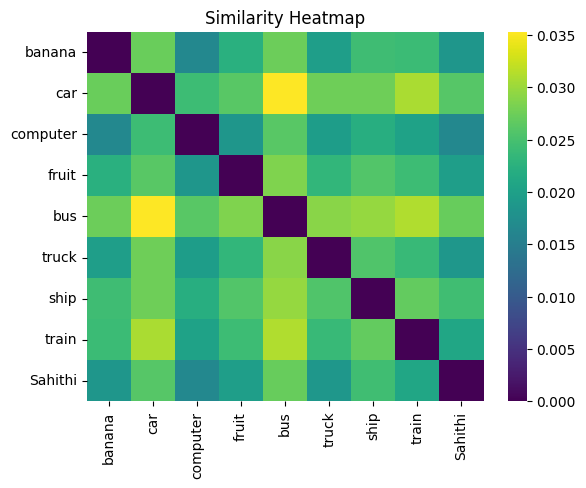

ranking for banana
1 computer
2 Sahithi
3 truck
4 fruit
5 train
6 ship
7 car
8 bus
ranking for car
1 computer
2 Sahithi
3 fruit
4 banana
5 truck
6 ship
7 train
8 bus
ranking for computer
1 Sahithi
2 banana
3 fruit
4 truck
5 train
6 ship
7 car
8 bus
ranking for fruit
1 computer
2 Sahithi
3 banana
4 truck
5 train
6 ship
7 car
8 bus
ranking for bus
1 computer
2 Sahithi
3 banana
4 fruit
5 truck
6 ship
7 train
8 car
ranking for truck
1 Sahithi
2 computer
3 banana
4 fruit
5 train
6 ship
7 car
8 bus
ranking for ship
1 computer
2 banana
3 Sahithi
4 truck
5 fruit
6 train
7 car
8 bus
ranking for train
1 computer
2 Sahithi
3 truck
4 banana
5 fruit
6 ship
7 car
8 bus
ranking for Sahithi
1 computer
2 banana
3 truck
4 fruit
5 train
6 ship
7 car
8 bus


In [ ]:
visualize_dissimilarity(words, 'euclidean')
